In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Constants
SPLIT_THRESHOLD = 0.8


In [2]:
# Load squid data
squid_df = pd.read_excel('../dataset/squid-tweets/squid-dataset-cleaned.xlsx').drop('Unnamed: 0', axis=1).astype({'is-spam': np.float64})
squid_df.tail()

DF_LENGTH = squid_df.shape[0]

In [3]:
# Train-test split
draw = squid_df.sample(frac=1.0, random_state=42)
squid_train = draw[:int(SPLIT_THRESHOLD*DF_LENGTH)]
squid_valid = draw[int(SPLIT_THRESHOLD*DF_LENGTH):]

In [4]:
squid_valid.tail()

,tweets,is-spam
106,<username> If anything them banning it made it...,0.0
270,SQUID GAME\nepisode 1: c’monnnn let’s get to t...,0.0
860,New Drop Collection!💥\nFor fans of the series ...,1.0
435,<username> <username> not everyone was equal i...,0.0
102,WHERE'S MY SQUID GAME MEME REFERENCING OUR NEW...,0.0


In [5]:
# Load NLP stuff
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(squid_train['tweets'])

# Variables
dict_size = len(tokenizer.word_index)

print('Length: {}'.format(dict_size))
tokenizer.word_index

Length: 3152


{'<OOV>': 1,
 'game': 2,
 'squid': 3,
 'the': 4,
 'link': 5,
 'username': 6,
 'hashtag': 7,
 'i': 8,
 'to': 9,
 'and': 10,
 'a': 11,
 'of': 12,
 'is': 13,
 'in': 14,
 'it': 15,
 'for': 16,
 'you': 17,
 'on': 18,
 'that': 19,
 'but': 20,
 'was': 21,
 'my': 22,
 'this': 23,
 'with': 24,
 'just': 25,
 'me': 26,
 'from': 27,
 'like': 28,
 'are': 29,
 'so': 30,
 'about': 31,
 'be': 32,
 'have': 33,
 'as': 34,
 'not': 35,
 'at': 36,
 'watching': 37,
 'if': 38,
 'get': 39,
 'by': 40,
 'people': 41,
 'they': 42,
 'what': 43,
 'how': 44,
 'one': 45,
 'we': 46,
 'show': 47,
 'when': 48,
 'know': 49,
 'all': 50,
 'episode': 51,
 'up': 52,
 'out': 53,
 'why': 54,
 'do': 55,
 'no': 56,
 'watch': 57,
 'now': 58,
 'your': 59,
 'more': 60,
 'new': 61,
 'or': 62,
 'see': 63,
 'netflix': 64,
 'watched': 65,
 'an': 66,
 'he': 67,
 'really': 68,
 'would': 69,
 'good': 70,
 'some': 71,
 'finished': 72,
 'i’m': 73,
 'halloween': 74,
 'will': 75,
 'got': 76,
 '1': 77,
 'because': 78,
 'has': 79,
 'creator': 

In [6]:
squid_train_seq = tokenizer.texts_to_sequences(squid_train['tweets'])
squid_train_pad = tf.keras.preprocessing.sequence.pad_sequences(squid_train_seq, padding='pre', maxlen=60)

squid_valid_seq = tokenizer.texts_to_sequences(squid_valid['tweets'])
squid_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(squid_valid_seq, padding='pre', maxlen=60, truncating='post')

In [7]:
squid_valid_pad

array([[  0,   0,   0, ...,  12,   3,   2],
       [  0,   0,   0, ...,   8, 138,   1],
       [  0,   0,   0, ...,  14,  15,   1],
       ...,
       [  0,   0,   0, ...,   7,   7,   5],
       [  0,   0,   0, ...,  57,   4,  47],
       [  0,   0,   0, ...,   1,   1,   5]], dtype=int32)

In [12]:
len(tokenizer.word_index)

3152

In [8]:
PAD_MAX_LENGTH = 60

In [129]:
# Load model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, len(tokenizer.word_index)//2, input_length=PAD_MAX_LENGTH, trainable=True),
    # tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(256),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.GlobalAveragePooling1D(),
    # tf.keras.layers.Dense(32, activation=tf.nn.relu),
    # tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 60, 1576)          4969128   
_________________________________________________________________
lstm_49 (LSTM)               (None, 256)               1876992   
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 257       
Total params: 6,846,377
Trainable params: 6,846,377
Non-trainable params: 0
_________________________________________________________________


In [130]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(squid_train_pad, y=squid_train['is-spam'].values, epochs=300, batch_size=16, validation_data=(squid_valid_pad, squid_valid['is-spam'].values), verbose=2)

Epoch 1/300
52/52 - 3s - loss: 0.6908 - binary_accuracy: 0.6020 - val_loss: 0.6885 - val_binary_accuracy: 0.6780
Epoch 2/300
52/52 - 1s - loss: 0.6895 - binary_accuracy: 0.6422 - val_loss: 0.6874 - val_binary_accuracy: 0.6927
Epoch 3/300
52/52 - 1s - loss: 0.6883 - binary_accuracy: 0.6679 - val_loss: 0.6862 - val_binary_accuracy: 0.7317
Epoch 4/300
52/52 - 1s - loss: 0.6871 - binary_accuracy: 0.6911 - val_loss: 0.6851 - val_binary_accuracy: 0.7366
Epoch 5/300
52/52 - 1s - loss: 0.6859 - binary_accuracy: 0.7009 - val_loss: 0.6838 - val_binary_accuracy: 0.7463
Epoch 6/300
52/52 - 1s - loss: 0.6846 - binary_accuracy: 0.7143 - val_loss: 0.6826 - val_binary_accuracy: 0.7366
Epoch 7/300
52/52 - 1s - loss: 0.6833 - binary_accuracy: 0.7192 - val_loss: 0.6814 - val_binary_accuracy: 0.7317
Epoch 8/300
52/52 - 1s - loss: 0.6820 - binary_accuracy: 0.7241 - val_loss: 0.6802 - val_binary_accuracy: 0.7268
Epoch 9/300
52/52 - 1s - loss: 0.6807 - binary_accuracy: 0.7265 - val_loss: 0.6790 - val_binary_

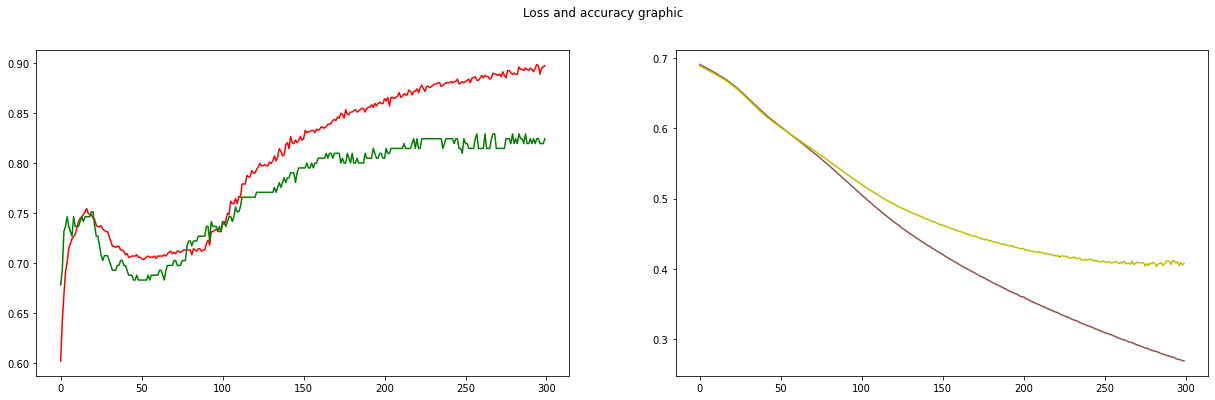

In [131]:
plt.rcParams['figure.figsize'] = (21,6)

fig, axs = plt.subplots(1, 2)
fig.suptitle('Loss and accuracy graphic')
axs[0].plot(range(len(history.history['loss'])), history.history['binary_accuracy'], 'r-', history.history['val_binary_accuracy'], 'g-')
axs[1].plot(range(len(history.history['loss'])), history.history['loss'], 'tab:brown', history.history['val_loss'], 'y')
plt.show()

In [132]:
model.save('../model/squid-spam-model')

INFO:tensorflow:Assets written to: ../model/squid-spam-model/assets


INFO:tensorflow:Assets written to: ../model/squid-spam-model/assets


In [125]:
# Saving tokenizer via pickle
import pickle
with open('../dataset/squid-tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)